# Dask Bag

## Задачи для совместного разбора

In [1]:
import dask.bag as db
import json

In [2]:
with open("posts.json") as fp:
    posts = json.load(fp)

In [3]:
posts

[{'userId': 1,
  'id': 1,
  'title': 'sunt aut facere repellat provident occaecati excepturi optio reprehenderit',
  'body': 'quia et suscipit\nsuscipit recusandae consequuntur expedita et cum\nreprehenderit molestiae ut ut quas totam\nnostrum rerum est autem sunt rem eveniet architecto'},
 {'userId': 1,
  'id': 2,
  'title': 'qui est esse',
  'body': 'est rerum tempore vitae\nsequi sint nihil reprehenderit dolor beatae ea dolores neque\nfugiat blanditiis voluptate porro vel nihil molestiae ut reiciendis\nqui aperiam non debitis possimus qui neque nisi nulla'},
 {'userId': 1,
  'id': 3,
  'title': 'ea molestias quasi exercitationem repellat qui ipsa sit aut',
  'body': 'et iusto sed quo iure\nvoluptatem occaecati omnis eligendi aut ad\nvoluptatem doloribus vel accusantium quis pariatur\nmolestiae porro eius odio et labore et velit aut'},
 {'userId': 1,
  'id': 4,
  'title': 'eum et est occaecati',
  'body': 'ullam et saepe reiciendis voluptatem adipisci\nsit amet autem assumenda provid

1. Посчитайте длину (в кол-ве символов) каждого заголовка.

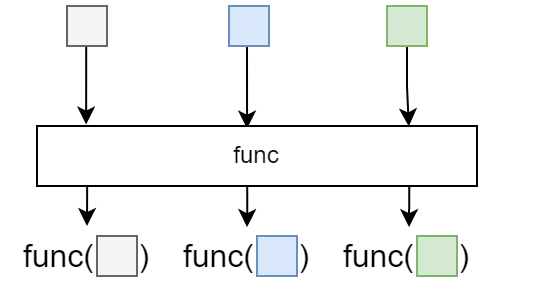

In [4]:
list(
    map(
    lambda p: len(p['title']),
    posts
    )
)[:5]

[74, 12, 59, 20, 18]

In [58]:
%%time
bag = db.from_sequence(posts)
bag

Wall time: 2 ms


dask.bag<from_sequence, npartitions=100>

In [7]:
bag = db.from_sequence(posts, npartitions=10)
bag.map(lambda p: len(p['title'])).compute()[:5]

[74, 12, 59, 20, 18]

2. Выведите id постов, длина заголовков которых не более 15 символов.

In [8]:
[p['id'] for p in posts if len(p['title']) <= 15]

[2, 40, 41, 57, 91]

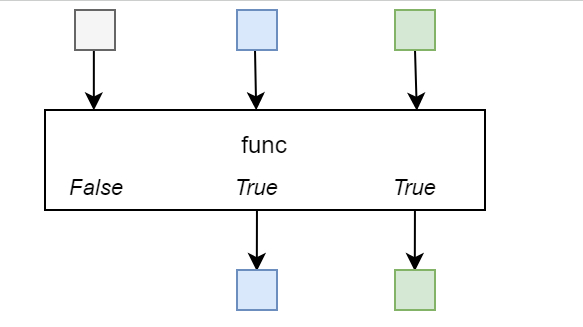

In [9]:
list(
    map( 
        lambda p: p['id'], 
        filter(
        lambda p: len(p['title']) <= 15,
        posts    
    )
  )      
)

[2, 40, 41, 57, 91]

In [10]:
bag.filter(lambda p: len(p['title']) <= 15).map(lambda p: p['id']).compute()[:5]

[2, 40, 41, 57, 91]

3. Посчитайте сумму длин описаний постов

In [11]:
sum(len(p['body']) for p in posts)

16064

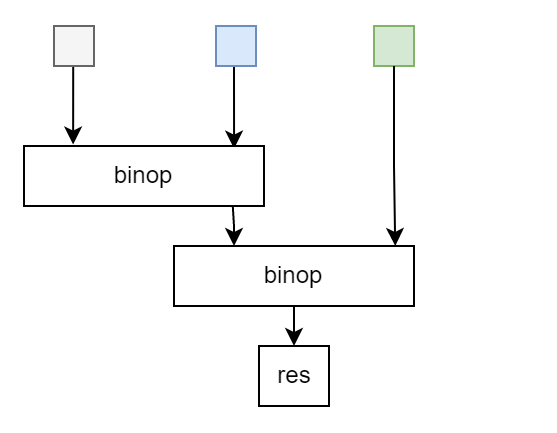

In [12]:
from functools import reduce

In [ ]:
# 1 2 3 

# (1 + 2)

# (3 + 3 = 6)

# (1+2) + 3 = 6 

In [13]:
reduce(
    lambda l, r: l + r,
    map(
        lambda p: len(p['body']),
        posts
    )   
)

16064

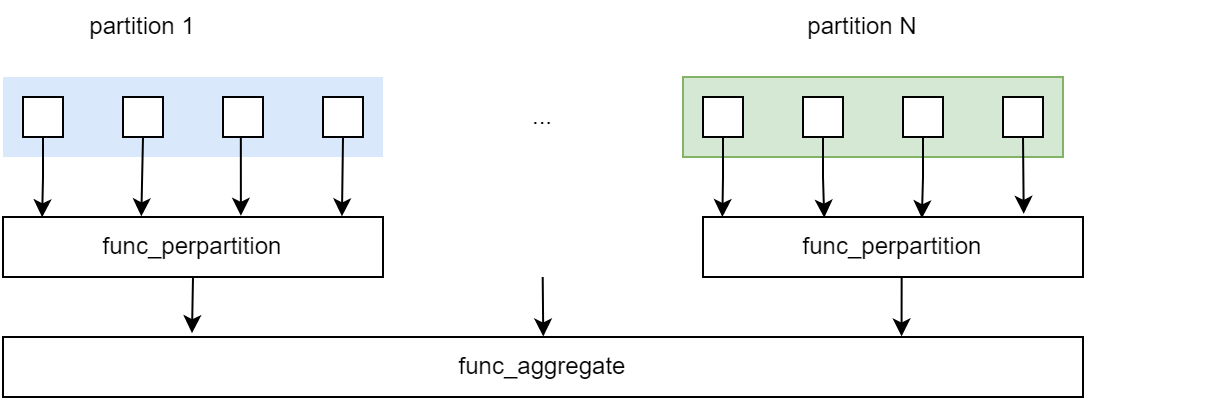

In [14]:
bag.map(lambda p: len(p['body'])).reduction(
    lambda partition: sum(partition),
    lambda partition_results: sum(partition_results)    
).compute()

16064

In [ ]:
class A:
    pass

a = A()

In [ ]:
# import pickle # pickle - это бинарник 

# with open('test.pickle') as
#     fp.dump()

4. При помощи метода `foldby` посчитайте, сколько постов написал каждый из пользователей.

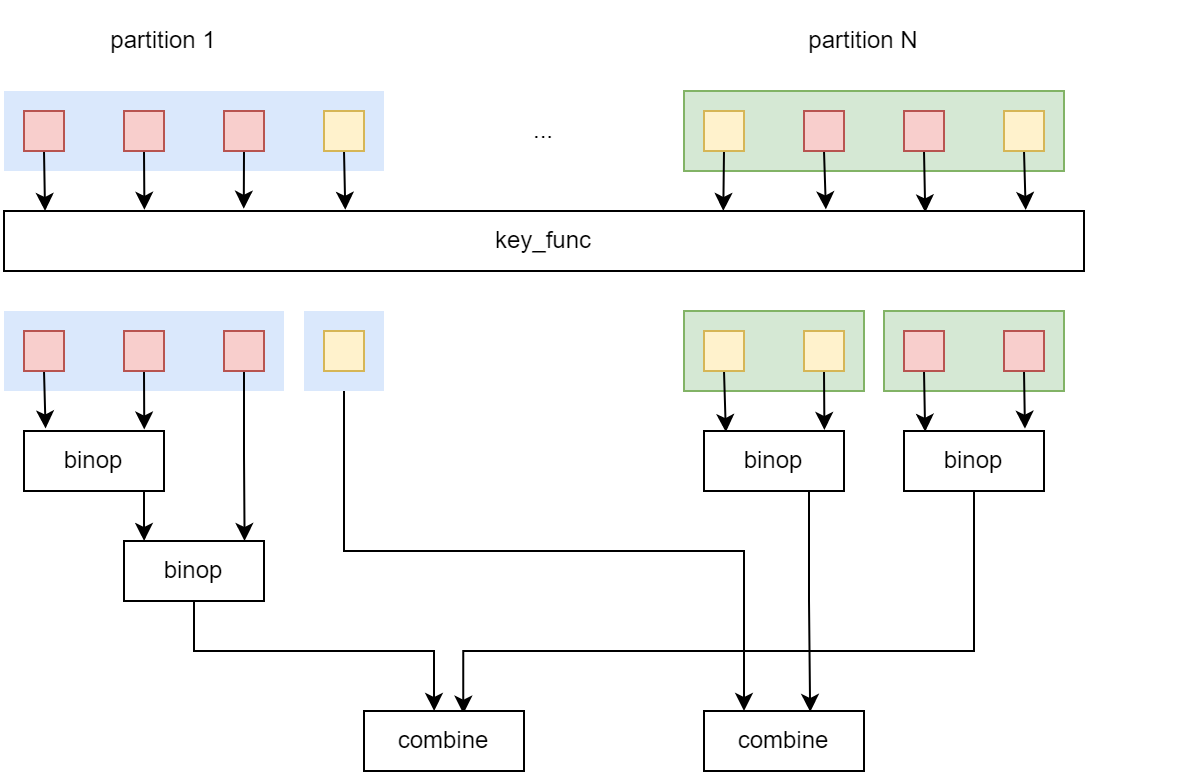

In [23]:
def binop(l, r):
    return l + 1

def combine(l, r):
    return l + r

bag.foldby(
    lambda p: p['userId'],
    binop,
    0,
    combine,
    0
).compute()

[(1, 10),
 (2, 10),
 (3, 10),
 (4, 10),
 (5, 10),
 (6, 10),
 (7, 10),
 (8, 10),
 (9, 10),
 (10, 10)]

## Лабораторная работа 12

__При решении данных задач не подразумевается использования циклов или генераторов Python в ходе работы с пакетами `numpy`, `pandas` и `dask`, если в задании не сказано обратного. Решения задач, в которых для обработки массивов `numpy`, структур `pandas` или структур `dask` используются явные циклы (без согласования с преподавателем), могут быть признаны некорректными и не засчитаны.__

В ходе выполнения все операции вычислений проводятся над `dask.bag` и средствами пакета `dask`, если в задании не сказано обратного. Переход от `dask.bag` к `pd.DataFrame` возможен исключительно для демонстрации результата в конце решения задачи. Если в задаче используются результаты выполнения предыдущих задач, то подразумевается, что вы используете результаты в виде `dask.bag` (то есть то, что было получено до вызова `compute`, а не после).

In [1]:
import re
import time
import json
import nltk
import dask
import numpy as np
import pandas as pd
import dask.bag as db
from itertools import chain
from functools import reduce
from nltk import word_tokenize
from collections import Counter
from operator import itemgetter
import matplotlib.pyplot as plt
from iteration_utilities import flatten

1\. В файлах архива `reviews_full.zip` находятся файлы, содержащие информацию об отзывах к рецептам в формате JSON Lines. Отзывы разделены на файлы в зависимости от оценки (например, в файле `reviews_1.json` находятся отзывы с оценкой 1). Считайте файлы из этого архива (предварительно разархивировав) в виде `dask.bag`. Преобразуйте текстовое содержимое файлов с помощью модуля `json`. Выведите на экран первые 5 элементов полученного `bag`.

In [2]:
bag = db.read_text('reviews_*.json').map(json.loads).take(5)
bag

({'user_id': 452355,
  'recipe_id': 292657,
  'date': '2016-05-08',
  'review': 'WOW!!! This is the best. I have never been able to make homemade enchiladas that taste like the Mexican restaurants. I made this last night for my family and they said they will never have enchiladas at the Mexican Restaurants again. Thanks for sharing.'},
 {'user_id': 329304,
  'recipe_id': 433404,
  'date': '2006-06-14',
  'review': 'This was good but the dressing needed something and I found it to be a little too sweet, next time I will experiment with some garlic and herbs and reduce the sugar slightly, thanks for sharing kcdlong!...Kitten'},
 {'user_id': 227932,
  'recipe_id': 2008187,
  'date': '1985-11-19',
  'review': 'Very good,it was a hit for my family. I used 6 cloves of garlic and had 1 lb beef and  Johnsonville sausage,1/2 lb hot and  1/2 lb honey garlic( which I wanted to use). That was a perfect combo for us. The sausage gave it nice flavor No guestion , I will be making this often.'},
 {'u

2\. Модифицируйте функцию разбора JSON таким образом, чтобы в каждый словарь c информацией об отзыве добавить ключ `rating`. Значение получите на основе названия файла (см. аргумент `include_path` функции `read_text`), использовав для этого регулярное выражение. При создании `bag` разбейте набор данных на сегменты размером 128 Мб (см. аргумент `blocksize`).  Выведите на экран первые 5 элементов полученного `bag`.

In [3]:
def upd_dict(bag):
    patt = re.compile(r"(reviews_\d)")
    d = json.loads(bag[0])
    d["rating"] = rating_num = int(patt.findall(bag[1])[0].split('_')[1])
    return d

In [4]:
num_2_bag = db.read_text('reviews_*.json', blocksize='128MiB', encoding='utf-8', include_path=True).map(upd_dict)
num_2_bag.take(5)

({'user_id': 452355,
  'recipe_id': 292657,
  'date': '2016-05-08',
  'review': 'WOW!!! This is the best. I have never been able to make homemade enchiladas that taste like the Mexican restaurants. I made this last night for my family and they said they will never have enchiladas at the Mexican Restaurants again. Thanks for sharing.',
  'rating': 0},
 {'user_id': 329304,
  'recipe_id': 433404,
  'date': '2006-06-14',
  'review': 'This was good but the dressing needed something and I found it to be a little too sweet, next time I will experiment with some garlic and herbs and reduce the sugar slightly, thanks for sharing kcdlong!...Kitten',
  'rating': 0},
 {'user_id': 227932,
  'recipe_id': 2008187,
  'date': '1985-11-19',
  'review': 'Very good,it was a hit for my family. I used 6 cloves of garlic and had 1 lb beef and  Johnsonville sausage,1/2 lb hot and  1/2 lb honey garlic( which I wanted to use). That was a perfect combo for us. The sausage gave it nice flavor No guestion , I will

3\. Посчитайте, сколько различных пользователей оставляли отзывы. Выведите это количество на экран.

In [14]:
num_3_bag = db.read_text('reviews_*.json').map(json.loads)
num_3_bag = num_3_bag.map(lambda x: x['user_id'])
res = len(set(num_3_bag.compute()))
res

226570

4\. Создайте версию `bag` из задания 2, в которой сохранены только отзывы, оставленные в 2014 и 2015 годах. Посчитайте и выведите на экран долю, которую составляют отзывы, оставленные в 2014 и 2015 году, среди всех отзывов.

In [15]:
patt = re.compile(r"((?:2014|2015)-\d\d-\d\d)")
count_1415 = num_2_bag.filter(lambda x: patt.findall(x["date"])).count().compute()
count_all = num_2_bag.map(lambda x: x['date']).count().compute()
frac = count_1415/count_all
print("Доля, которую составляют отзывы, оставленные в 2014 и 2015 году, среди всех отзывов: ", frac)

Доля, которую составляют отзывы, оставленные в 2014 и 2015 году, среди всех отзывов:  0.08117811237929945


5\. Для отзывов, оставленных в мае 2013 года, выполните предобработку: 
   * приведите строки к нижнему регистру;
   * обрежьте пробельные символы в начале и конце строки;
   * удалите все символы, кроме английских букв и пробелов.
   
Посчитайте и выведите на экран среднюю длину этих отзывов после предобработки. Если текстовое содержимое отзыва отсутствует, считайте, что длина отзыва равна нулю.

In [16]:
patt_eng = re.compile(r"[^a-zA-Z\s]+")
patt_2013 = re.compile(r"((?:2013)-(?:05)-\d\d)")

bag_filtered_2013 = num_2_bag.filter(lambda x: patt_2013.findall(x["date"]))
bag_of_reviews = bag_filtered_2013.map(lambda x: x["review"].strip().lower()) 
bag_of_reviews = bag_of_reviews.map(lambda x: re.sub(r"[^a-zA-Z\s]+", "", x))

sum_len_of_all_strings = sum(map(len, bag_of_reviews.compute()))

len_of_bag = len(bag_filtered_2013.compute())
print("Средняя длина этих отзывов после предобработки: ", sum_len_of_all_strings/len_of_bag)

Средняя длина этих отзывов после предобработки:  269.2301560494494


6\. Посчитайте, как часто встречается та или иная оценка:

   * в 2014 году;
   * в 2015 году.

Создайте `pd.DataFrame`, содержащий 2 столбца: `2014`, `2015` и 6 строк, имеющие индексы строк от 0 до 5. Дайте индексам строк имя `rating`. Выведите полученную таблицу на экран.

In [17]:
patt_2014 = re.compile(r"(?:2014)")
patt_2015 = re.compile(r"(?:2015)")

bag_filtered_2014 = num_2_bag.filter(lambda x: patt_2014.findall(x["date"]))
rating_stats_2014 = bag_filtered_2014.map(lambda x: Counter(x).get("rating")).compute()
bag_filtered_2015 = num_2_bag.filter(lambda x: patt_2015.findall(x["date"]))
rating_stats_2015 = bag_filtered_2015.map(lambda x: Counter(x).get("rating")).compute()

d = {'rating': list(np.unique(rating_stats_2014, return_counts=True)[0]),
     '2014': list(np.unique(rating_stats_2014, return_counts=True)[1]),
     '2015': list(np.unique(rating_stats_2015, return_counts=True)[1])}
df_answ = pd.DataFrame(data=d)
df_answ = df_answ.set_index('rating')

df_answ

,2014,2015
rating,,
0,21136,21336
1,4344,4902
2,4507,4873
3,12865,13667
4,58433,60980
5,258832,269399


7\.  Перераспределите данные из исходного `bag` на $k, k=2, 16, 32, 64, 128$ частей. Для каждого разбиения измерьте время выполнения расчета среднего рейтинга. Визуализируйте зависимость времени выполнения функции от числа сегментов. Временем, затрачиваемым на вызов метода `repartition`, можно пренебречь. Для итерации по $k$ допускается использовать циклы.

### k = 2

In [14]:
start_time = time.time()

bag_k_2 = num_2_bag.repartition(2)
sum_of_ratings_bag_k_2 = bag_k_2.map(lambda x: x['rating']).sum().compute()
len_of_bag_k_2 = bag_k_2.map(lambda x: x['rating']).count().compute()
average_rating_bag_k_2 = sum_of_ratings_bag_k_2/len_of_bag_k_2

spended_time_bag_k_2 = round(time.time() - start_time, 2)

print("Средний рейтинг: ", average_rating_bag_k_2)
print(spended_time_bag_k_2)

Средний рейтинг:  4.410805803783367
331.69


### k = 16

In [22]:
start_time = time.time()

bag_k_16 = num_2_bag.repartition(16)
sum_of_ratings_bag_k_16 = bag_k_16.map(lambda x: x['rating']).sum().compute()
len_of_bag_k_16 = bag_k_16.map(lambda x: x['rating']).count().compute()
average_rating_bag_k_16 = sum_of_ratings_bag_k_16/len_of_bag_k_16

spended_time_bag_k_16 = round(time.time() - start_time, 2)

print("Средний рейтинг: ", average_rating_bag_k_16)
print(spended_time_bag_k_16)

Средний рейтинг:  4.410805803783367
230.57


### k = 32

In [23]:
start_time = time.time()

bag_k_32 = num_2_bag.repartition(32)
sum_of_ratings_bag_k_32 = bag_k_32.map(lambda x: x['rating']).sum().compute()
len_of_bag_k_32 = bag_k_32.map(lambda x: x['rating']).count().compute()
average_rating_bag_k_32 = sum_of_ratings_bag_k_32/len_of_bag_k_32

spended_time_bag_k_32 = round(time.time() - start_time, 2)

print("Средний рейтинг: ", average_rating_bag_k_32)
print(spended_time_bag_k_32)

Средний рейтинг:  4.410805803783367
36.95


### k = 64

In [24]:
start_time = time.time()

bag_k_64 = num_2_bag.repartition(64)
sum_of_ratings_bag_k_64 = bag_k_64.map(lambda x: x['rating']).sum().compute()
len_of_bag_k_64 = bag_k_64.map(lambda x: x['rating']).count().compute()
average_rating_bag_k_64 = sum_of_ratings_bag_k_64/len_of_bag_k_64

spended_time_bag_k_64 = round(time.time() - start_time, 2)

print("Средний рейтинг: ", average_rating_bag_k_64)
print(spended_time_bag_k_64)

Средний рейтинг:  4.410805803783367
342.9


### k = 128

In [25]:
start_time = time.time()

bag_k_128 = num_2_bag.repartition(128)
sum_of_ratings_bag_k_128 = bag_k_128.map(lambda x: x['rating']).sum().compute()
len_of_bag_k_128 = bag_k_128.map(lambda x: x['rating']).count().compute()
average_rating_bag_k_128 = sum_of_ratings_bag_k_128/len_of_bag_k_128

spended_time_bag_k_128 = round(time.time() - start_time, 2)

print("Средний рейтинг: ", average_rating_bag_k_128)
print(spended_time_bag_k_128)

Средний рейтинг:  4.410805803783367
544.78


In [26]:
df_summar = pd.DataFrame(data={'time': [spended_time_bag_k_2, spended_time_bag_k_16, 
                                        spended_time_bag_k_32, spended_time_bag_k_64, spended_time_bag_k_128],
                               'k': [2, 16, 32, 64, 128]})
df_summar

,time,k
0,324.33,2
1,230.57,16
2,36.95,32
3,342.90,64
4,544.78,128


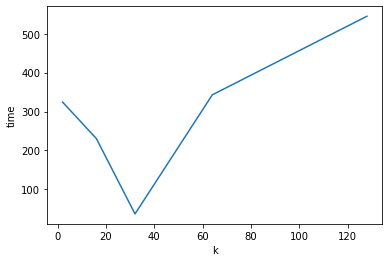

In [29]:
plt.plot(df_summar.k, df_summar.time)
plt.xlabel('k')
plt.ylabel('time')
plt.show()

##### Можно сделать вывод, что самым оптимальным количеством разбиений является k = 32, а самым не оптимальным k = 128

8\. Будем считать, что сегмент _плохо перемешан_, если в нем _подряд_ идет 5 или более отзывов, оставленных в один и тот же год. Воспользовавшись методом `map_partitions`, посчитайте и выведите на экран, сколько сегментов оказались _плохо перемешанными_ в `bag` из задачи 2. Также выведите на экран общее количество сегментов в `bag`, для которого производились расчеты.

In [ ]:
def f(partition):
    prev_y = None
    curr_len = 0
    
    for year in partition:
        if year == prev_y:
            curr_len += 1
            if curr_len >= 5:
                return (1, )
        else:
            curr_len = 1
            prev_y = year
            
    return (0, )

num_2_bag.pluck('year').map_partition(f).sum().compute()

9\. Используя метод `foldby`, подсчитайте и выведите на экран максимальную длину отзывов в зависимости от оценки `rating` в наборе, полученном в задании 2.

In [10]:
def binop(rat, am):
    max_val = max((rat, am), key=lambda x: x[1])
    return max_val

max_len_rating = num_2_bag.map(lambda b: tuple([b['rating'], len(str(b['review'] or ''))])).foldby(lambda x: x[0], binop).compute()
max_len_rating

[(0, (0, 6972)),
 (1, (1, 5567)),
 (2, (2, 6972)),
 (3, (3, 4954)),
 (4, (4, 8587)),
 (5, (5, 8587))]